In [1]:
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import Counter
from pymystem3 import Mystem
from classification_model import train_test_datasets, NeuralNetwork, train_nn, predict, multilabel_accuracy
from data_preprocessing import clean_data, apply_n_grams, vectorize_text
import re
import math
import torch
import torch.nn as nn
import pickle
import numpy as np
from gensim.models import Word2Vec

In [2]:
habr = pd.read_json('habr_info.json')
habr

,time,tags,habs,saved,comments,views,field
0,2016-04-11T09:29:03.000Z,"[безопасная динамичность, brave, блокировка ре...","[управление, медиа]",4,0,1749,"[11, 6]"
1,2016-04-09T14:19:17.000Z,"[dash, блокчейн, криптовалюта, управление]","[венчурный_инвестиция, фриланс]",12,7,10370,"[11, 11]"
2,2016-04-10T05:11:42.000Z,"[mail.ru group, headhunter, российский рынок, ...","[it, карьера, индустрия, бизнес_модель, бизнес]",12,1,5472,"[9, 11, 11, 11, 11]"
3,2016-04-11T17:05:54.000Z,"[tidal, jay-z, канье уэст, стриминговые сервисы]","[веб, сервис, монетизация]",3,1,3706,"[7, 12, 6]"
4,2016-04-09T14:52:55.000Z,"[mozilla, brave, блокировщики рекламы, судебно...","[it, законодательство]",4,7,6244,"[9, 11]"
...,...,...,...,...,...,...,...
38066,2021-11-11T07:34:51.000Z,[cisco],"[компания, блог, информационный, безопасность,...",3,1,2098,"[1, 1, 5, 5, 3, 2]"
38067,2021-11-11T08:22:05.000Z,"[георезервирование, резервирование каналов, dr...","[it, технология, инфраструктура, сетевой, серв...",6,2,773,"[9, 3, 3, 3, 12, 2]"
38068,2021-11-11T11:13:02.000Z,"[газоразрядный индикатор, имг-1-02, гип-10000,...","[программирование, микроконтроллер, старый_жел...",61,37,11593,"[4, 4, 2, 2, 2]"
38069,2021-11-11T11:55:58.000Z,"[минцифры, госуслуги, ddos, атака]","[компания, it, инфраструктура, законодательство]",1,13,3796,"[1, 9, 3, 11]"


In [3]:
fields = {2 : 'Железо, электроника',
         3 : 'Сетевые технологии, администрирование, devops',
         4 : 'Проектирование, тестирование',
         5 : 'Информационная безопасность',
         6 : 'Маркетинг, контекстная реклама',
         7 : 'Верстка, html, javascript',
         8 : 'Машинное обучение',
         9 : 'E-commerce, финансы',
         10 : 'Дизайн интерфейсов',
         11 : 'Бизнес, CRM',
         12 : 'SEO'}

In [4]:
list(fields.values())

['Железо, электроника',
 'Сетевые технологии, администрирование, devops',
 'Проектирование, тестирование',
 'Информационная безопасность',
 'Маркетинг, контекстная реклама',
 'Верстка, html, javascript',
 'Машинное обучение',
 'E-commerce, финансы',
 'Дизайн интерфейсов',
 'Бизнес, CRM',
 'SEO']

In [5]:
word2vec_model = Word2Vec.load('habr_vocab_model_on_text')

In [6]:
habr_train = pd.DataFrame(columns = ['text', 'vector'] + list(fields.values()))
habr_train['text'] = habr['habs']
habr_train

,text,vector,"Железо, электроника","Сетевые технологии, администрирование, devops","Проектирование, тестирование",Информационная безопасность,"Маркетинг, контекстная реклама","Верстка, html, javascript",Машинное обучение,"E-commerce, финансы",Дизайн интерфейсов,"Бизнес, CRM",SEO
0,"[управление, медиа]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[венчурный_инвестиция, фриланс]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[it, карьера, индустрия, бизнес_модель, бизнес]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[веб, сервис, монетизация]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[it, законодательство]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38066,"[компания, блог, информационный, безопасность,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38067,"[it, технология, инфраструктура, сетевой, серв...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38068,"[программирование, микроконтроллер, старый_жел...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38069,"[компания, it, инфраструктура, законодательство]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
for row in tqdm(habr_train.index):
    field = habr['field'][row]
    for i in field:
        try:
            habr_train[fields[i]][row] = 1
        except:
            pass
habr_train

100%|██████████| 38071/38071 [00:39<00:00, 961.03it/s] 


,text,vector,"Железо, электроника","Сетевые технологии, администрирование, devops","Проектирование, тестирование",Информационная безопасность,"Маркетинг, контекстная реклама","Верстка, html, javascript",Машинное обучение,"E-commerce, финансы",Дизайн интерфейсов,"Бизнес, CRM",SEO
0,"[управление, медиа]",NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN
1,"[венчурный_инвестиция, фриланс]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,"[it, карьера, индустрия, бизнес_модель, бизнес]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN
3,"[веб, сервис, монетизация]",NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1
4,"[it, законодательство]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38066,"[компания, блог, информационный, безопасность,...",NaN,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38067,"[it, технология, инфраструктура, сетевой, серв...",NaN,1,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1
38068,"[программирование, микроконтроллер, старый_жел...",NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38069,"[компания, it, инфраструктура, законодательство]",NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN


## Подготовка признаков

In [8]:
habr_train['vector'] = habr_train['text'].apply(vectorize_text, word2vec_model=word2vec_model)
habr_train.head()

,text,vector,"Железо, электроника","Сетевые технологии, администрирование, devops","Проектирование, тестирование",Информационная безопасность,"Маркетинг, контекстная реклама","Верстка, html, javascript",Машинное обучение,"E-commerce, финансы",Дизайн интерфейсов,"Бизнес, CRM",SEO
0,"[управление, медиа]","[1.0165791515052585, -3.3254490851902085, 1.09...",NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN
1,"[венчурный_инвестиция, фриланс]","[0.10593617155309246, -2.514573099078407, 1.54...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,"[it, карьера, индустрия, бизнес_модель, бизнес]","[1.723850427013645, -2.5026189406031056, 1.670...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN
3,"[веб, сервис, монетизация]","[1.1284584994131674, -1.9374364310853287, 1.32...",NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1
4,"[it, законодательство]","[1.3535158214303824, -2.1436565939779912, 1.10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN


In [51]:
habr_train = habr_train.dropna(subset=['vector'])
habr_train = habr_train.fillna(0)
habr_train.head()

,text,vector,"Железо, электроника","Сетевые технологии, администрирование, devops","Проектирование, тестирование",Информационная безопасность,"Маркетинг, контекстная реклама","Верстка, html, javascript",Машинное обучение,"E-commerce, финансы",Дизайн интерфейсов,"Бизнес, CRM",SEO
0,"[управление, медиа]","[1.0165791515052585, -3.3254490851902085, 1.09...",0,0,0,0,1,0,0,0,0,1,0
1,"[венчурный_инвестиция, фриланс]","[0.10593617155309246, -2.514573099078407, 1.54...",0,0,0,0,0,0,0,0,0,1,0
2,"[it, карьера, индустрия, бизнес_модель, бизнес]","[1.723850427013645, -2.5026189406031056, 1.670...",0,0,0,0,0,0,0,1,0,1,0
3,"[веб, сервис, монетизация]","[1.1284584994131674, -1.9374364310853287, 1.32...",0,0,0,0,1,1,0,0,0,0,1
4,"[it, законодательство]","[1.3535158214303824, -2.1436565939779912, 1.10...",0,0,0,0,0,0,0,1,0,1,0


In [55]:
habr = habr.loc[habr_train.index]

In [57]:
habr_train.index = np.arange(len(habr_train))
habr.index = np.arange(len(habr_train))

## Обучение модели

In [11]:
target_list = list(fields.values())
train_size = 0.8
train = habr_train.sample(frac=train_size, random_state=200).reset_index(drop=True)
test = habr_train.drop(train.index).reset_index(drop=True)

train_loader, test_loader = train_test_datasets(train, test, target_list)

In [12]:
model = NeuralNetwork()

In [13]:
epochs = 100
history = []
criterion = nn.CrossEntropyLoss()      
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

train_nn(model, train_loader, criterion, optimizer, epochs, history)

1	 loss: 3.13793683052063
2	 loss: 2.767260789871216
3	 loss: 2.3984482288360596
4	 loss: 2.443693161010742
5	 loss: 2.4091155529022217
6	 loss: 2.9292945861816406
7	 loss: 2.2757034301757812
8	 loss: 3.115243434906006
9	 loss: 2.39755916595459
10	 loss: 1.955024242401123
11	 loss: 2.1006219387054443
12	 loss: 1.6789699792861938
13	 loss: 1.8115828037261963
14	 loss: 1.790723204612732
15	 loss: 2.1672279834747314
16	 loss: 2.2580554485321045
17	 loss: 2.434842348098755
18	 loss: 1.7979536056518555
19	 loss: 2.044210195541382
20	 loss: 1.7333015203475952
21	 loss: 2.488039016723633
22	 loss: 2.0035080909729004
23	 loss: 2.10361385345459
24	 loss: 2.058572292327881
25	 loss: 2.5000295639038086
26	 loss: 2.326910972595215
27	 loss: 2.11450457572937
28	 loss: 2.3328847885131836
29	 loss: 2.1688756942749023
30	 loss: 2.209071397781372
31	 loss: 1.7018285989761353
32	 loss: 1.422423005104065
33	 loss: 1.925767183303833
34	 loss: 2.2842109203338623
35	 loss: 2.513065814971924
36	 loss: 2.1979

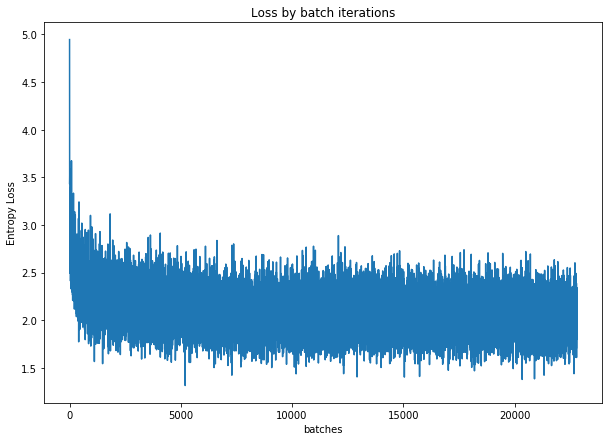

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

### Получим предсказания

In [15]:
predictions = predict(model, test_loader)

### Протестируем модель

In [19]:
target = []

for row in test[target_list].index:
    target_i = []
    values = test[target_list].iloc[row].values
    for j in range(len(values)):
        if values[j] == 1:
            target_i.append(j)
    target.append(target_i)

In [20]:
print("Model's accuracy:", multilabel_accuracy(predictions, target))

Model's accuracy: 0.9454651642160244


### Сохраним модель

In [21]:
torch.save(model.state_dict(), "nn_classifier")

### Итоговый датасет Habr

In [59]:
def norm_field(row):
    norm_fields = []
    for i in set(row):
        if i >= 2:
            norm_fields.append(i - 2)
    return norm_fields
habr['field'] = habr['field'].apply(norm_field)  
habr

,time,tags,habs,saved,comments,views,field
0,2016-04-11T09:29:03.000Z,"[безопасная динамичность, brave, блокировка ре...","[управление, медиа]",4,0,1749,"[9, 4]"
1,2016-04-09T14:19:17.000Z,"[dash, блокчейн, криптовалюта, управление]","[венчурный_инвестиция, фриланс]",12,7,10370,[9]
2,2016-04-10T05:11:42.000Z,"[mail.ru group, headhunter, российский рынок, ...","[it, карьера, индустрия, бизнес_модель, бизнес]",12,1,5472,"[7, 9]"
3,2016-04-11T17:05:54.000Z,"[tidal, jay-z, канье уэст, стриминговые сервисы]","[веб, сервис, монетизация]",3,1,3706,"[10, 4, 5]"
4,2016-04-09T14:52:55.000Z,"[mozilla, brave, блокировщики рекламы, судебно...","[it, законодательство]",4,7,6244,"[7, 9]"
...,...,...,...,...,...,...,...
36379,2021-11-11T07:34:51.000Z,[cisco],"[компания, блог, информационный, безопасность,...",3,1,2098,"[0, 1, 3]"
36380,2021-11-11T08:22:05.000Z,"[георезервирование, резервирование каналов, dr...","[it, технология, инфраструктура, сетевой, серв...",6,2,773,"[7, 0, 1, 10]"
36381,2021-11-11T11:13:02.000Z,"[газоразрядный индикатор, имг-1-02, гип-10000,...","[программирование, микроконтроллер, старый_жел...",61,37,11593,"[0, 2]"
36382,2021-11-11T11:55:58.000Z,"[минцифры, госуслуги, ddos, атака]","[компания, it, инфраструктура, законодательство]",1,13,3796,"[9, 1, 7]"


In [64]:
def get_field(row):
    all_fields = []
    for i in row:
        all_fields.append(fields[i + 2])
    return all_fields
habr['field'] = habr['field'].apply(get_field)
habr

,time,tags,habs,saved,comments,views,field
0,2016-04-11T09:29:03.000Z,"[безопасная динамичность, brave, блокировка ре...","[управление, медиа]",4,0,1749,"[Бизнес, CRM, Маркетинг, контекстная реклама]"
1,2016-04-09T14:19:17.000Z,"[dash, блокчейн, криптовалюта, управление]","[венчурный_инвестиция, фриланс]",12,7,10370,"[Бизнес, CRM]"
2,2016-04-10T05:11:42.000Z,"[mail.ru group, headhunter, российский рынок, ...","[it, карьера, индустрия, бизнес_модель, бизнес]",12,1,5472,"[E-commerce, финансы, Бизнес, CRM]"
3,2016-04-11T17:05:54.000Z,"[tidal, jay-z, канье уэст, стриминговые сервисы]","[веб, сервис, монетизация]",3,1,3706,"[SEO, Маркетинг, контекстная реклама, Верстка,..."
4,2016-04-09T14:52:55.000Z,"[mozilla, brave, блокировщики рекламы, судебно...","[it, законодательство]",4,7,6244,"[E-commerce, финансы, Бизнес, CRM]"
...,...,...,...,...,...,...,...
36379,2021-11-11T07:34:51.000Z,[cisco],"[компания, блог, информационный, безопасность,...",3,1,2098,"[Железо, электроника, Сетевые технологии, адми..."
36380,2021-11-11T08:22:05.000Z,"[георезервирование, резервирование каналов, dr...","[it, технология, инфраструктура, сетевой, серв...",6,2,773,"[E-commerce, финансы, Железо, электроника, Сет..."
36381,2021-11-11T11:13:02.000Z,"[газоразрядный индикатор, имг-1-02, гип-10000,...","[программирование, микроконтроллер, старый_жел...",61,37,11593,"[Железо, электроника, Проектирование, тестиров..."
36382,2021-11-11T11:55:58.000Z,"[минцифры, госуслуги, ddos, атака]","[компания, it, инфраструктура, законодательство]",1,13,3796,"[Бизнес, CRM, Сетевые технологии, администриро..."


In [65]:
#habr.to_json('habr_final.json')